<a href="https://colab.research.google.com/github/SampMark/Recommender-Systems/blob/main/Collaborative_Filtering_Recommender_System_Pearson_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema de Recomendação baseado em Filtragem Colaborativa e Fatoração de Matrizes**

Historicamente, um dos primeiros métodos para sistemas de recomendação foi o [k-Nearest Neighbors (KNN)](https://github.com/SampMark/Machine-Learning/blob/main/K_Nearest_Neighbors.ipynb). Essa abordagem baseia-se em identificar usuários (ou itens) similares:

- **Similaridade entre usuários:** se dois usuários possuem um histórico de avaliações parecido, as preferências de um podem ser usadas para prever as do outro.
- **Similaridade entre Itens:** alternativamente, se dois itens são avaliados de forma semelhante por vários usuários, a avaliação de um item pode ajudar a prever a avaliação do outro.

A abordagem de classificação pelo KNN pode ser considerada intuitiva, mas pode enfrentar dificuldades com escalabilidade e precisão em bases de dados muito grandes.

Outra técnica bastante utilizada em sistemas de recomendação é a **filtragem colaborativa**, por meio da fatoração de matrizes, que se baseia na ideia de que "_pessoas com gostos semelhantes tendem a gostar de coisas parecidas_".

Em vez de analisar os atributos dos itens, como na abordagem [baseada em conteúdo](https://github.com/SampMark/Recommender-Systems/blob/main/Content_Based_Recommendation_System.ipynb), a **filtragem colaborativa** explora as interações entre usuários e itens para identificar padrões de preferência e assim gerar recomendações melhores.

Essa abordagem consiste em decompor a matriz original (muito esparsa) em duas ou mais matrizes menores que capturam os fatores latentes (características ocultas) tanto dos usuários quanto dos itens. Os principais pontos dessa abordagem são:

- **Descoberta de Fatores Latentes:** em vez de utilizar características explícitas (como gênero ou diretor), o algoritmo identifica padrões implícitos que explicam as preferências dos usuários.
- **Previsão de Avaliações:** a multiplicação das matrizes fatoradas permite estimar a avaliação que um usuário daria a um item não avaliado.
- **Escalabilidade:** essa abordagem lida melhor com grandes volumes de dados e a alta esparsidade da matriz de avaliações.

Existem duas abordagens principais na filtragem colaborativa:

* **Baseada em Usuário:**
    * Identifica usuários com histórico de avaliações similar ao do usuário alvo.
    * Recomenda itens que foram bem avaliados pelos usuários similares, mas que o usuário alvo ainda não conhece.
      * Exemplo: Se o usuário A e o usuário B deram notas altas para os filmes X e Y, o sistema pode recomendar o filme Z, que o usuário A gostou, para o usuário B.
* **Baseada em Item:**
    * Calcula a similaridade entre os itens com base nas avaliações dos usuários.
    * Recomenda itens similares aos que o usuário já avaliou positivamente.
      * Exemplo: Se os usuários A e B deram notas altas para os filmes X e Z, o sistema pode recomendar o filme Y, similar a X e Z, para outros usuários com preferências semelhantes.

**Vantagens da Filtragem Colaborativa**

* **Simplicidade:** a lógica por trás da filtragem colaborativa é intuitiva e fácil de entender.
* **Eficácia:**  em muitos casos, a filtragem colaborativa produz recomendações precisas e relevantes.
* **Serendipidade:**  ou ato de descobrir coisas por acaso, de forma inesperada, ou de encontrar soluções para problemas sem querer, pode levar à descoberta de itens inesperados que o usuário não encontraria por conta própria.

**Desafios da Filtragem Colaborativa**

* **Esparsidade de Dados:**  A maioria dos usuários avalia apenas uma pequena fração dos itens disponíveis, o que dificulta o cálculo da similaridade e a geração de recomendações.
* **_Cold Start_:**  O sistema tem dificuldades em recomendar itens para novos usuários ou novos itens que ainda não possuem avaliações suficientes.
* **Escalabilidade:**  O cálculo da similaridade pode se tornar computacionalmente caro à medida que o número de usuários e itens cresce.

Em resumo, a filtragem colaborativa via fatoração de matrizes tornou-se dominante por superar as limitações dos métodos baseados em regressão e k-NN, ao extrair informações relevantes diretamente dos padrões de comportamento dos usuários.

---



In [1]:
# @title Importando as bibliotecas
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Explorando o Dataset do MovieLens**

O conjunto de dados explorado é do [**MovieLens Datasets**](https://dl.acm.org/doi/10.1145/2827872), o qual traz avaliações de filmes coletadas pelo Grupo de Pesquisa GroupLens na Universidade de Minnesota.

O conjunto de dados contém mais de 22,8 milhões de avaliações de 34,2 mil filmes, é um dos conjuntos de dados mais populares usados na pesquisa de sistemas de recomendação.


### **Explorando o arquivo de dados `'movies.csv'`**

---



In [2]:
movies_df = pd.read_csv('/content/drive/MyDrive/dados/ml-latest/movies.csv')

# Informações gerais sobre o dataset
print("\nVisão geral do dataset:")
print(f"- Número de linhas: {movies_df.shape[0]} títulos de filmes")
print(f"- Número de colunas: {movies_df.shape[1]}")

# Verificar as primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
movies_df.head()


Visão geral do dataset:
- Número de linhas: 34208 títulos de filmes
- Número de colunas: 3

Primeiras 5 linhas do dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Mostrar informações sobre colunas e tipos de dados
print("\nInformações das colunas:")
print(movies_df.info())


Informações das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  34208 non-null  int64 
 1   title    34208 non-null  object
 2   genres   34208 non-null  object
dtypes: int64(1), object(2)
memory usage: 801.9+ KB
None


### **Explorando o arquivo de dados `'ratings.csv'`**

---

In [4]:
ratings_df = pd.read_csv('/content/drive/MyDrive/dados/ml-latest/ratings.csv')

# Informações gerais sobre o dataset
print("\nVisão geral do dataset:")
print(f"- Número de linhas: {ratings_df.shape[0]}")
print(f"- Número de colunas: {ratings_df.shape[1]}")

# Verificar as primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
ratings_df.head()


Visão geral do dataset:
- Número de linhas: 22884377
- Número de colunas: 4

Primeiras 5 linhas do dataset:


,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


In [5]:
# Mostrar informações sobre colunas e tipos de dados
print("\nInformações das colunas:")
print(ratings_df.info())


Informações das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 698.4 MB
None


## **Pré-processamento dos dados**

---



In [6]:
# Extraindo para uma coluna o ano armazenado entre parênteses
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)

# Removendo o ano do título e limpando espaços
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

# Visualizando o DataFrame atualizado
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Primeiro ano: 1874.0
Último ano: 2016.0


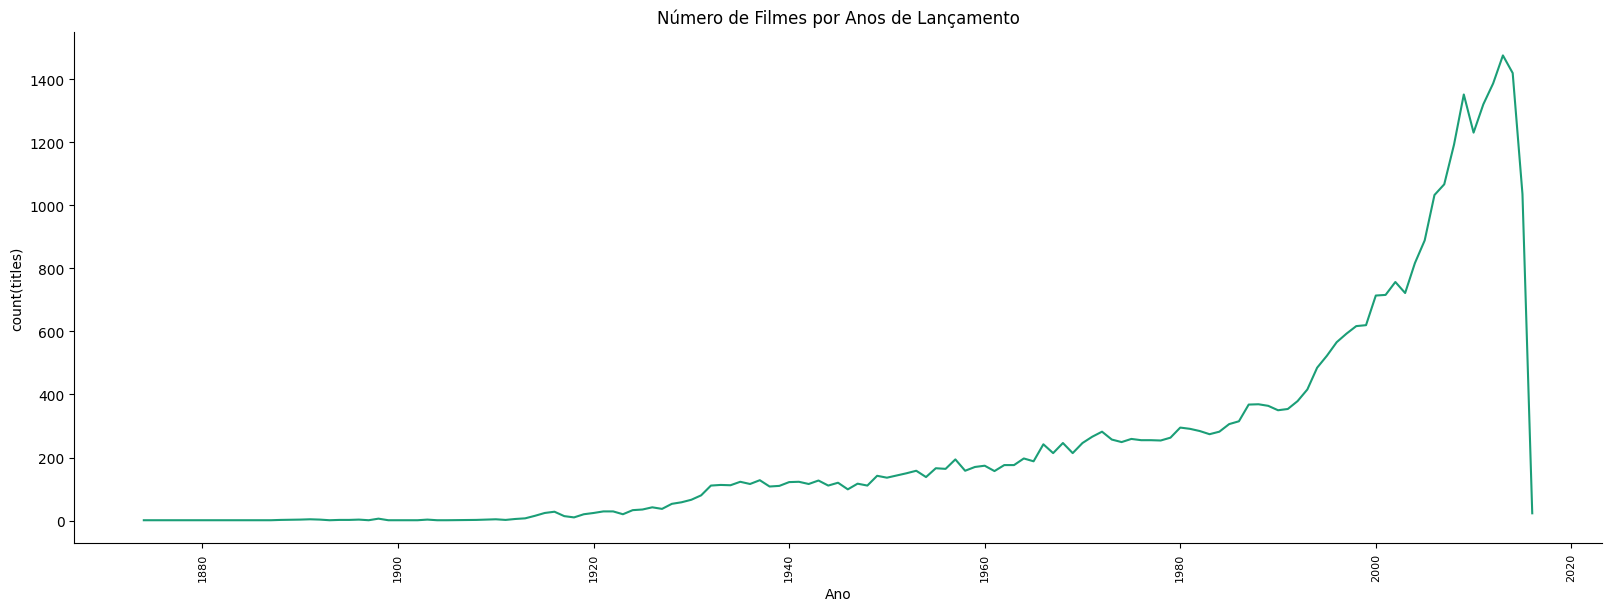

In [7]:
# Converter a coluna 'year' em numérica, manipulando erros
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')

# Imprimir o primeiro e último ano da série de filmes
print(f"Primeiro ano: {movies_df['year'].min()}")
print(f"Último ano: {movies_df['year'].max()}")

def plot_series(series, series_name, series_index=0):
    """
    Plota um gráfico de linha mostrando a contagem de filmes por ano.

    Args:
        series (pd.Series): Série contendo os anos de lançamento dos filmes.
        series_name (str): Nome da série para a legenda do gráfico.
        series_index (int): Índice da série para seleção de cores.
    """
    palette = list(sns.palettes.mpl_palette('Dark2'))  # Define a paleta de cores.
    counted = (series['year']  # Conta a ocorrência de cada ano.
                .value_counts()
                .reset_index(name='counts')  # Renomeia a coluna de contagem.
                .rename({'index': 'year'}, axis=1)  # Renomeia a coluna de anos.
                .sort_values('year', ascending=True))  # Ordena os dados por ano.
    xs = counted['year']  # Define os valores do eixo x.
    ys = counted['counts']  # Define os valores do eixo y.
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])  # Plota o gráfico.

# Cria a figura e o eixo do gráfico.
fig, ax = plt.subplots(figsize=(16, 6), layout='constrained')

# Ordena o DataFrame 'movies_df' por ano de lançamento.
df_sorted = movies_df.sort_values('year', ascending=True)

# Rotacionar os anos para melhor visualização
plt.xticks(rotation=90, fontsize=8)

# Plota o gráfico de contagem de filmes por ano.
plot_series(df_sorted, '')

# Remove as bordas superior e direita do gráfico.
sns.despine(fig=fig, ax=ax)

# Adicionar rótulos e título ao gráfico
plt.xlabel('Ano')
plt.title('Número de Filmes por Anos de Lançamento')

# Define o rótulo do eixo y.
_ = plt.ylabel('count(titles)')

<ipython-input-8-50fa839b4ff3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


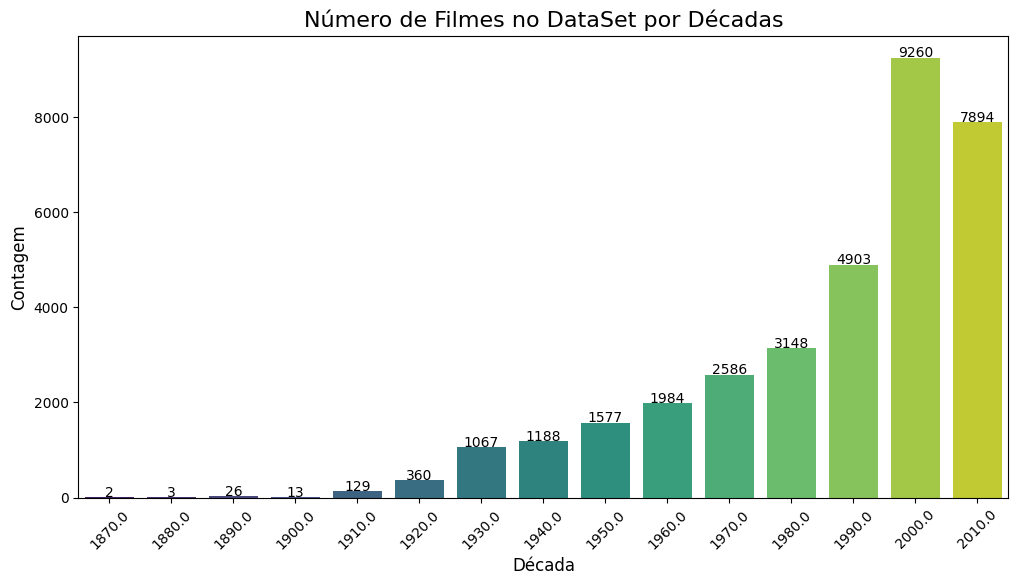

In [8]:
# Agrupar os anos por décadas
movies_df['decade'] = (movies_df['year'] // 10) * 10
decade_counts = movies_df['decade'].value_counts().sort_index()

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Configuração do gráfico
sns.barplot(
    x=decade_counts.index,
    y=decade_counts.values,
    palette='viridis'
)

# Adicionar os totais no topo de cada barra
for index, value in enumerate(decade_counts.values):
    plt.text(index, value + 10, str(value), ha='center', fontsize=10)

# Configurar rótulos e título do gráfico
plt.xticks(rotation=45)
plt.title("Número de Filmes no DataSet por Décadas", fontsize=16)
plt.xlabel("Década", fontsize=12)
plt.ylabel("Contagem", fontsize=12)

# Exibir o gráfico
plt.show()

In [9]:
movies_df.head()

,movieId,title,genres,year,decade
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,1990.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,1990.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,1990.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,1990.0
4,5,Father of the Bride Part II,Comedy,1995.0,1990.0


In [10]:
# Visualizar os primeiros registros do DataFrame
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


In [11]:
# Abandonando a coluna de timestamp
ratings_df = ratings_df.drop('timestamp', axis=1, errors='ignore')
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


## **Funcionamento da Filtragem Colaborativa**

A técnica de Filtragem Colaborativa, frequentemente chamada de "Filtragem Usuário-Usuário", baseia-se na análise do comportamento de outros usuários para gerar recomendações personalizadas. Como o próprio nome sugere, esse método identifica usuários com preferências e opiniões semelhantes ao usuário-alvo (entrada) e utiliza essas semelhanças para recomendar itens que eles aprovaram.

Essa abordagem é considerada interessante porque explora o comportamento coletivo, partindo do pressuposto de que pessoas com gostos semelhantes provavelmente gostarão das mesmas coisas. Existem diversas maneiras de identificar usuários semelhantes, incluindo métodos baseados em aprendizado de máquina. Neste contexto, utilizaremos a correlação de Pearson como métrica de similaridade. Em linhas gerais os sistemas funcionam da seguinte forma:

1. **Coleta de Dados:** o sistema coleta dados sobre as interações dos usuários com os itens, geralmente na forma de avaliações explícitas (notas, curtidas) ou implícitas (histórico de compras, tempo de visualização).
2. **Cálculo de Similaridade:** em seguida são utilizadas técnicas estatísticas como correlação de Pearson, similaridade de cosseno ou [distância euclidiana](https://github.com/SampMark/Computational-Thinking/blob/main/Minkowski_Manhattan_and_Euclidean_distance_metrics.ipynb), o sistema calcula a similaridade entre usuários (na abordagem baseada em usuário) ou entre itens (na abordagem baseada em item).
3. **Predição de Avaliação:** com base na similaridade e nas avaliações dos X vizinhos (usuários ou itens similares), o sistema prevê a avaliação que o usuário alvo daria a um item ainda não avaliado.
4. **Recomendação:** Os itens com as maiores avaliações previstas são recomendados ao usuário.

### **Utilização de técnicas robustas**

* **Técnicas de Similaridade:** a escolha da técnica de similaridade impacta a performance do sistema.
  * A correlação de Pearson mede a relação linear entre as avaliações, enquanto a similaridade de cosseno considera o ângulo entre os vetores de avaliação. A distância euclidiana mede a distância entre os pontos no espaço de avaliações.
* **Métricas de Avaliação:** a precisão das recomendações é avaliada com métricas como precisão, recall, F1-score e NDCG (_Normalized Discounted Cumulative Gain_).
* **Estratégias para Lidar com a Esparsidade:** técnicas de redução de dimensionalidade, como a decomposição em valores singulares (SVD), podem ser utilizadas para lidar com a esparsidade de dados.
* **Hibridização:** combinar a filtragem colaborativa com outras técnicas, como a baseada em conteúdo, pode superar as limitações do _cold start_ e melhorar a qualidade das recomendações.

## **Criação do Sistema de Recomendação Simples pelo Método de Filtragem Colaborativa**

---
1. **Selecionar um usuário-alvo**: Identificar um usuário para o qual deseja criar recomendações, compilar os filmes que ele já assistiu.
2. **Encontrar vizinhos mais próximos**: com base nas avaliações dos filmes, determine os X usuários mais semelhantes ao usuário-alvo.
3. **Obter o histórico dos vizinhos**: extrair os registros de filmes assistidos pelos vizinhos identificados.
4. **Calcular a similaridade**: aplicar a correlação de Pearson (neste caso) para medir o grau de semelhança entre as preferências do usuário-alvo e de seus vizinhos.


In [12]:
# Dados de entrada fornecidos pelo usuário
userInput = [
    {"title": "Titanic", "rating": 4.8},
    {"title": "Schindler's List", "rating": 4.5},
    {"title": "Beautiful Mind, A", "rating": 4.6},
    {"title": "Pursuit of Happyness, The", "rating": 4.0},
    {"title": "Last Samurai, The", "rating": 4.0},
    {"title": "Finding Nemo", "rating": 3.8},
]

# Validação para garantir que todos os itens têm as chaves esperadas
required_keys = {"title", "rating"}
for item in userInput:
    if not required_keys.issubset(item):
        raise ValueError(f"Chaves ausentes na entrada: {item}")

# Criação do DataFrame a partir dos dados do usuário
inputMovies = pd.DataFrame(userInput)

# Exibir o DataFrame
inputMovies

,title,rating
0,Titanic,4.8
1,Schindler's List,4.5
2,"Beautiful Mind, A",4.6
3,"Pursuit of Happyness, The",4.0
4,"Last Samurai, The",4.0
5,Finding Nemo,3.8


In [13]:
# Filtra o DataFrame 'movies_df' para incluir apenas os filmes presentes na lista de entrada.
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]

# Faz o merge do DataFrame 'input_id' com o DataFrame 'input_movies' com base no título do filme, combinando as informações dos filmes de entrada com seus respectivos IDs.
inputMovies = pd.merge(inputId, inputMovies, on='title')

# Remove as colunas 'year' e 'decade' do DataFrame 'input_movies', pois não será utilizadas no processo de recomendação.
inputMovies = inputMovies.drop(['year', 'decade'], axis=1)

# Exibe o DataFrame 'input_movies' resultante, que contém os filmes de entrada com seus IDs e avaliações, sem a coluna 'year'.
# Se um filme adicionado na lista acima não estiver presente, ele pode não estar no DataFrame original ou pode ter sido escrito de forma diferente. Verifique a capitalização e a ortografia.
inputMovies

,movieId,title,genres,rating
0,527,Schindler's List,Drama|War,4.5
1,1721,Titanic,Drama|Romance,4.8
2,3404,Titanic,Action|Drama,4.8
3,4995,"Beautiful Mind, A",Drama|Romance,4.6
4,6377,Finding Nemo,Adventure|Animation|Children|Comedy,3.8
5,7143,"Last Samurai, The",Action|Adventure|Drama|War,4.0
6,47099,"Pursuit of Happyness, The",Drama,4.0
7,118916,Titanic,Action|Drama|Romance,4.8


In [14]:
# Filtrar usuários que assistiram a filmes que o usuário alvo assistiu e armazená-los
# Filtra o DataFrame 'ratings_df' para incluir apenas as avaliações dos filmes presentes na lista de entrada do usuário.
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]

# Exibe as 5 primeiras linhas do DataFrame 'user_subset'.
userSubset.head()

,userId,movieId,rating
30,4,527,3.0
240,7,527,4.0
801,15,527,4.0
905,15,1721,2.5
1027,15,4995,4.5


In [15]:
# Agrupa o DataFrame 'user_subset' por 'userId', criando um objeto GroupBy.
userSubsetGroup = userSubset.groupby(['userId'])

# Exibe o subconjunto de avaliações do usuário com ID 1130.
userSubsetGroup.get_group((1130,))

,userId,movieId,rating
104743,1130,4995,3.5
104804,1130,6377,4.0


In [16]:
# Ordena o objeto GroupBy 'userSubsetGroup' com base no número de elementos em cada grupo
# Os grupos são ordenados em ordem decrescente de tamanho
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

# Exibe os 3 maiores grupos em termos de tamanho
userSubsetGroup[0:3]

[((2452,),
          userId  movieId  rating
  224211    2452      527     5.0
  224311    2452     1721     3.5
  224511    2452     4995     4.0
  224580    2452     6377     2.5
  224616    2452     7143     2.0
  224773    2452    47099     3.5
  225163    2452   118916     1.5),
 ((4415,),
          userId  movieId  rating
  408928    4415      527     2.0
  409284    4415     1721     4.0
  409841    4415     3404     0.5
  410240    4415     4995     3.0
  410462    4415     6377     4.5
  410560    4415     7143     3.0
  410979    4415    47099     4.0),
 ((6530,),
          userId  movieId  rating
  611725    6530      527     4.5
  612137    6530     1721     3.5
  612962    6530     4995     3.5
  613160    6530     6377     3.0
  613270    6530     7143     4.0
  613617    6530    47099     3.5
  614225    6530   118916     3.0)]

## **Cálculo da Similaridade dos Usuários com o Usuário-alvo**: usando o Coeficiente de Correlação de Pearson

---



Nesta etapa, o objetivo é comparar todos os usuários (na verdade, não todos!!!) ao usuário-alvo para encontrar aqueles mais semelhantes.

A ideia básica é descobrir o quão semelhante cada usuário é à entrada por meio do **Coeficiente de Correlação de Pearson**, usado para medir a força de uma associação linear linear entre dois conjuntos de valores 𝑋 e 𝑌, cada um contendo 𝑁 elementos. Esse coeficiente é amplamente utilizado em sistemas de recomendação para determinar similaridades entre usuários ou itens com base em suas avaliações.

**Mas por que aplicar a Correlação de Pearson?**

A correlação de Pearson é invariante à escala, ou seja, multiplicar todos os elementos por uma constante diferente de zero ou adicionar qualquer constante a todos os elementos. Por exemplo, imagine dois vetores X e Y, então, pearson(X, Y) == pearson(X, 2 * Y + 3).

Esta é uma propriedade muito importante em sistemas de recomendação porque, por exemplo, dois usuários podem classificar duas séries de itens de forma totalmente diferente em termos de taxas absolutas, mas seriam usuários semelhantes (ou seja, com ideias semelhantes) com taxas semelhantes em várias escalas.

**Fórmula do Coeficiente de Correlação de Pearson**:


$$ r = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}} $$

Onde:
- $ \ x_i \ $: Valor de $ \ X \ $ na posição $ \ i\ $
- $ \ y_i \ $: Valor de $ \ Y \ $ na posição $ \ i\ $
- $ \ \bar{x} \ $: Média dos valores de $ \ X \ $
- $ \ \bar{y} \ $: Média dos valores de $ \ Y \ $
- $ \ n \ $: Número total de elementos em $ \ X \ $ e $ \ Y \ $

Interpretação do Coeficiente $ \ r \ $:
- $ \ r = 1\ $: Correlação linear perfeita e positiva entre $ \ X \ $ e $ \ Y \ $.
- $ \ r = -1\ $: Correlação linear perfeita e negativa entre $ \ X \ $ e $ \ Y \ $.
- $ \ r = 0\ $: Nenhuma correlação linear (os conjuntos podem ser independentes).


In [17]:
# Limitando o subconjunto de usuários para os 100 primeiros
userSubsetGroup = userSubsetGroup[:100]

# Dicionário para armazenar os coeficientes de correlação de Pearson
pearsonCorrelationDict = {}

# Iterar sobre cada grupo de usuários
for user_id, group in userSubsetGroup:
    # Ordenar os filmes por 'movieId' para garantir consistência
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')

    # Número de avaliações em comum
    nRatings = len(group)

    # Selecionar filmes avaliados em comum entre o grupo atual e o usuário de entrada
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]

    # Listas de avaliações do usuário de entrada e do grupo
    tempRatingList = temp_df['rating'].tolist()
    tempGroupList = group['rating'].tolist()

    # Cálculo dos termos necessários para o coeficiente de correlação de Pearson
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList), 2) / float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList), 2) / float(nRatings)
    Sxy = sum(i * j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList) * sum(tempGroupList) / float(nRatings)

    # Calcular o coeficiente de correlação de Pearson
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[user_id] = Sxy / sqrt(Sxx * Syy)
    else:
        # Correlação é zero se um dos termos for nulo
        pearsonCorrelationDict[user_id] = 0

In [18]:
# Importar biblioteca para exibição tabular
from prettytable import PrettyTable

# Criar uma tabela para exibição legível dos resultados
def display_pearson_correlation(pearsonCorrelationDict):
    """
    Exibe o dicionário de correlação de Pearson em formato de tabela.

    Args:
        correlation_dict (dict): Dicionário contendo os IDs dos usuários como chaves
                                 e os coeficientes de correlação como valores.
    """
    # Inicializa a tabela com cabeçalhos
    top_users = PrettyTable(["User ID", "Pearson Correlation"])
    top_users.align["User ID"] = "l"
    top_users.align["Pearson Correlation"] = "r"

    # Adiciona os dados do dicionário à tabela
    for user_id, correlation in sorted(pearsonCorrelationDict.items(), key=lambda x: x[1], reverse=True):
        top_users.add_row([user_id, f"{correlation:.4f}"])

    # Retorna a tabela criada
    return top_users

# Exibe os resultados ordenados por correlação em ordem decrecente
# Chame a função e atribui o resultado a variável
top_users_table = display_pearson_correlation(pearsonCorrelationDict)
print(top_users_table)

+-----------+---------------------+
| User ID   | Pearson Correlation |
+-----------+---------------------+
| (5227,)   |              0.9536 |
| (1971,)   |              0.8010 |
| (9033,)   |              0.7829 |
| (17501,)  |              0.7730 |
| (15474,)  |              0.7614 |
| (5576,)   |              0.7530 |
| (815,)    |              0.7416 |
| (17498,)  |              0.7385 |
| (14257,)  |              0.6498 |
| (5104,)   |              0.6396 |
| (9051,)   |              0.6295 |
| (10298,)  |              0.5889 |
| (43514,)  |              0.5868 |
| (14588,)  |              0.5676 |
| (11905,)  |              0.5509 |
| (210950,) |              0.5459 |
| (4208,)   |              0.5381 |
| (1250,)   |              0.5176 |
| (12728,)  |              0.4927 |
| (9929,)   |              0.4541 |
| (18051,)  |              0.4459 |
| (10707,)  |              0.4262 |
| (6952,)   |              0.4087 |
| (7278,)   |              0.3904 |
| (14545,)  |              0

In [19]:
# Convert the PrettyTable to a pandas DataFrame to use .head()
top_users = pd.DataFrame(top_users_table._rows, columns=top_users_table._field_names) #This converts the PrettyTable to a pandas DataFrame

top_users.head() #Now you can use .head() as you intended

,User ID,Pearson Correlation
0,"(5227,)",0.9536
1,"(1971,)",0.8010
2,"(9033,)",0.7829
3,"(17501,)",0.7730
4,"(15474,)",0.7614


## **Cálculo da Média Ponderada das Avaliações**

---



Para calcular a média ponderada das avaliações dos filmes será utilizada a Correlação de Pearson como peso.

Primeiramente, serão identificados os filmes assistidos pelos usuários presentes no DataFrame `pearson_df`, extraindo essa informação do DataFrame de avaliações (`ratings_df`). Em seguida, serão armazenados os índices de Correlação de Pearson em uma nova coluna chamada `similarityIndex`. Para realizar essa etapa, faremos a junção (`merge`) das duas tabelas.

In [20]:
# Converte a coluna 'User ID' do DataFrame 'top_users' para o tipo inteiro
# Note que estamos usando 'User ID' com espaço, ao invés de 'userId'
top_users['User ID'] = top_users['User ID'].apply(lambda x: x[0] if isinstance(x, tuple) else x).astype(int)

# Converte a coluna 'userId' do DataFrame 'ratings_df' para o tipo inteiro
ratings_df['userId'] = ratings_df['userId'].astype(int)

# Mescla o DataFrame 'topUsers' com o DataFrame 'ratings_df' com base na coluna 'userId'.
# Usamos 'User ID' para a coluna do DataFrame 'top_users' e 'userId' para a coluna do DataFrame 'ratings_df'
top_users_ratings = top_users.merge(ratings_df, left_on='User ID', right_on='userId', how='inner')

# Exibe as 5 primeiras linhas do DataFrame 'top_users_ratings'.
top_users_ratings.head()

,User ID,Pearson Correlation,userId,movieId,rating
0,5227,0.9536,5227,32,3.5
1,5227,0.9536,5227,47,4.0
2,5227,0.9536,5227,110,4.0
3,5227,0.9536,5227,111,4.0
4,5227,0.9536,5227,253,3.0


In [21]:
# Multiplica a similaridade pelas avaliações do usuário
# Calcula a avaliação ponderada para cada filme no DataFrame 'topUsersRating'
# Renomeia a coluna 'Pearson Correlation' para 'similarityIndex'
top_users_ratings = top_users_ratings.rename(columns={'Pearson Correlation': 'similarityIndex'})

# Converte a coluna 'similarityIndex' para numérico
top_users_ratings['similarityIndex'] = pd.to_numeric(top_users_ratings['similarityIndex'])

# Calcula a avaliação ponderada
top_users_ratings['weightedRating'] = top_users_ratings['similarityIndex'] * top_users_ratings['rating']

# Exibe as 5 primeiras linhas do DataFrame
top_users_ratings.head()

,User ID,similarityIndex,userId,movieId,rating,weightedRating
0,5227,0.9536,5227,32,3.5,3.3376
1,5227,0.9536,5227,47,4.0,3.8144
2,5227,0.9536,5227,110,4.0,3.8144
3,5227,0.9536,5227,111,4.0,3.8144
4,5227,0.9536,5227,253,3.0,2.8608


In [22]:
# Agrupa o DataFrame 'top_users_ratings' por 'movieId' e calcula a soma das colunas 'similarityIndex' e 'weightedRating' para cada filme
temp_top_users_ratings = top_users_ratings.groupby('movieId').sum()[['similarityIndex','weightedRating']]

# Renomeia as colunas do DataFrame 'temp_top_users_ratings' para 'sum_similarityIndex' e 'sum_weightedRating'
temp_top_users_ratings.columns = ['sum_similarityIndex','sum_weightedRating']

# Exibe as 5 primeiras linhas do DataFrame
temp_top_users_ratings.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,6.9482,20.75060
2,6.3677,19.45860
3,3.8292,10.34555
4,1.6753,2.04470
5,2.7351,5.15095


In [23]:
# Cria um DataFrame vazio chamado 'recommendation_df'
recommendation_df = pd.DataFrame()

# Calcula a média ponderada das avaliações e armazena na coluna 'Pontuação de recomendação média ponderada'
recommendation_df['Pontuação de recomendação (média ponderada)'] = temp_top_users_ratings['sum_weightedRating'] / temp_top_users_ratings['sum_similarityIndex']

# Define a coluna 'movieId' do DataFrame 'recommendation_df' com os índices do DataFrame 'tempTopUsersRating'.
recommendation_df['movieId'] = temp_top_users_ratings.index

# Exibe as 5 primeiras linhas do DataFrame
recommendation_df.head()

,Pontuação de recomendação (média ponderada),movieId
movieId,,
1,2.986471,1
2,3.055829,2
3,2.701752,3
4,1.220498,4
5,1.883277,5


In [24]:
# Ordena o DataFrame 'recommendation_df' pela coluna 'pontuação de recomendação média ponderada' em ordem decrescente.
recommendation_df = recommendation_df.sort_values(by='Pontuação de recomendação (média ponderada)', ascending=False)

# Exibe as 10 primeiras linhas do DataFrame 'recommendation_df'.
recommendation_df.head(20)

,Pontuação de recomendação (média ponderada),movieId
movieId,,
4106,1644.625000,4106
65359,344.014286,65359
4219,185.206897,4219
8134,178.750000,8134
2374,134.737500,2374
26996,116.811688,26996
7845,105.523810,7845
138036,104.983871,138036
112006,95.228916,112006


In [25]:
# Filtra o DataFrame 'movies_df' para exibir os filmes correspondentes às 20 maiores pontuações de recomendação
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(20)['movieId'].tolist())][['title', 'year', 'genres']]

,title,year,genres
2290,Gung Ho,1986.0,Comedy|Drama
2550,"Mummy, The",1959.0,Horror
4013,Extreme Prejudice,1987.0,Action|Crime|Drama|Thriller|Western
4126,Girls Just Want to Have Fun,1985.0,Comedy
4408,Ernest Saves Christmas,1988.0,Children|Comedy
4999,Rollerball,2002.0,Action|Sci-Fi
7312,Connie and Carla,2004.0,Comedy
7521,Tremors II: Aftershocks,1996.0,Comedy|Horror|Sci-Fi
7667,Wonderful Days (a.k.a. Sky Blue),2003.0,Animation|Sci-Fi
7925,Tokyo Godfathers,2003.0,Adventure|Animation|Drama


# **Referências**

  F. Maxwell Harper and Joseph A. Konstan. 2015. **The MovieLens Datasets: History and Context**. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=<http://dx.doi.org/10.1145/2827872>

  MASSACHUSETTS INSTITUTE OF TECHNOLOGY. **MITx 6.86x Machine Learning with Python-From Linear Models to Deep Learning**. Cambridge, MA: edX, 2023. Disponível em: https://www.edx.org/learn/machine-learning/massachusetts-institute-of-technology-machine-learning-with-python-from-linear-models-to-deep-learning. Acesso em: 5 de janeiro de 2025.